# Project 03: Decision Tree


## Import Libraries


In [28]:
import graphviz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz


In [29]:
from constants.path import DATA_WDBC, DATA_WINE, FIG_DIR
from constants.base import RATIOS
from utils import display_ratio, normalize_dataset_name, normalize_dataset_ratio


## Dataset Loading and Preprocessing


In [30]:
breast_df = pd.read_csv(DATA_WDBC, sep=",")
# Map labels (M=0, B=1) to align with sklearn's encoding
breast_df = breast_df[breast_df["Diagnosis"].isin(["M", "B"])]

# Prepare features and labels
y_breast = breast_df["Diagnosis"].map({"M": 0, "B": 1})
X_breast = breast_df.drop("Diagnosis", axis=1)

# Verify dataset integrity
# print("Unique Diagnosis values:", breast_df["Diagnosis"].unique())
# print("Unique y_breast:", y_breast.unique())
# print("Number of features:", X_breast.shape[1])
# print("Feature Names:\n", len(X_breast.columns.tolist()), (X_breast.columns.tolist()))
# print("\nClass Distribution:\n", y_breast.value_counts())


In [31]:
wine_df = pd.read_csv(DATA_WINE, sep=",")
# Group into 3 quality categories
wine_df["quality_group"] = pd.cut(
    wine_df["quality"], bins=[-1, 4, 6, 10], labels=["Low", "Standard", "High"]
)

# Prepare features and labels
y_wine = wine_df["quality_group"]
X_wine = wine_df.drop(["quality", "quality_group"], axis=1)

# Verify class distribution
# print("Quality Group Distribution:")
# print(y_wine.value_counts())


In [32]:
"""
Additional Dataset: Car Evaluation Dataset

This dataset meets all project requirements:
	+ Source: UCI Machine Learning Repository
	+ Classes: 4 (unacc, acc, good, vgood)
	+ Samples: 1728

Features: 6 categorical attributes (buying price, maintenance cost, doors, etc.).
"""

# column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
# car_df = pd.read_csv(DATA_CARS, header=None, names=column_names)

# # One-Hot Encode Categorical Features
# y_car = car_df["class"]
# X_car = pd.get_dummies(car_df.drop("class", axis=1))

# # Verify Dataset Compliance
# print(f"Total Samples: {len(car_df)}")  # Output: 1728
# print("Class Distribution:\n", y_car.value_counts())

# Class Distribution (Example Output):
# unacc    1210
# acc       384
# good       69
# vgood      65


'\nAdditional Dataset: Car Evaluation Dataset\n\nThis dataset meets all project requirements:\n\t+ Source: UCI Machine Learning Repository\n\t+ Classes: 4 (unacc, acc, good, vgood)\n\t+ Samples: 1728\n\nFeatures: 6 categorical attributes (buying price, maintenance cost, doors, etc.).\n'

## 2.1 - Data Splitting and Visualization


In [33]:
def split_and_visualize(X, y, dataset_name: str):
    splits = {}

    for ratio in RATIOS:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=ratio, stratify=y, shuffle=True, random_state=42
        )

        splits[ratio] = (X_train, X_test, y_train, y_test)

        # Class distribution visualization
        _, axes = plt.subplots(1, 3, figsize=(18, 4))
        (
            pd.Series(y)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[0], title=f"Original ({len(y)} samples)")
        )
        (
            pd.Series(y_train)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[1], title=f"Train ({len(y_train)} samples)")
        )
        (
            pd.Series(y_test)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[2], title=f"Test ({len(y_test)} samples)")
        )

        plt.suptitle(f"{dataset_name} - {display_ratio(ratio)} Split")
        plt.tight_layout()
        plt.savefig(
            f"{FIG_DIR}/class_dist__{normalize_dataset_name(dataset_name)}__{normalize_dataset_ratio(ratio)}.png"
        )
        plt.show()
        plt.close()

    return splits


## 2.2, 2.3 - Decision Tree Training and Evaluation


In [34]:
def train_evaluate_decision_tree(
    X_train,
    y_train,
    X_test,
    y_test,
    dataset_name: str,
    split_ratio,
):
    # Dynamically set feature and class names
    feature_names = X_train.columns.tolist()
    class_names = [str(cls) for cls in np.unique(y_train)]

    # Train model
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Classification Report (with validation)
    print(f"\nClassification Report ({dataset_name}, {display_ratio(split_ratio)}):")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=class_names,
            labels=np.unique(y_test),  # Ensure alignment with actual classes
        )
    )

    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {dataset_name} ({display_ratio(split_ratio)})")
    plt.savefig(
        f"{FIG_DIR}/confusion_mat__{normalize_dataset_name(dataset_name)}__{normalize_dataset_ratio(split_ratio)}.png"
    )
    plt.show()
    plt.close()

    # Export Decision Tree Visualization
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
    )
    img = mpimg.imread(
        graphviz.Source(dot_data).render(
            f"{FIG_DIR}/dt__{normalize_dataset_name(dataset_name)}__{normalize_dataset_ratio(split_ratio)}",
            format="png",
            cleanup=True,
        )
    )
    height, width = img.shape[:2]
    dpi = plt.rcParams["figure.dpi"]
    _, ax = plt.subplots(figsize=(width / dpi, height / dpi))
    ax.imshow(img)
    ax.axis("off")

    plt.title(f"Decision Tree - {dataset_name} ({display_ratio(split_ratio)})")
    plt.show()
    plt.close()


## 2.4 - Depth vs. Accuracy Analysis (80/20 Split)


In [35]:
def depth_accuracy_analysis(X, y, feature_names, class_names, dataset_name: str):
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, stratify=y, shuffle=True, random_state=42
    )

    # Test depths
    max_depths = [None, 2, 3, 4, 5, 6, 7]
    accuracies = []

    for depth in max_depths:
        # Train with depth constraint
        clf = DecisionTreeClassifier(
            criterion="entropy", max_depth=depth, random_state=42
        )
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        accuracies.append(acc)

        dot_data = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            rounded=True,
        )
        img = mpimg.imread(
            graphviz.Source(dot_data).render(
                f"{FIG_DIR}/dt__{normalize_dataset_name(dataset_name)}__{normalize_dataset_ratio(0.8)}__{depth}",
                format="png",
                cleanup=True,
            )
        )
        height, width = img.shape[:2]
        dpi = plt.rcParams["figure.dpi"]
        _, ax = plt.subplots(figsize=(width / dpi, height / dpi))
        ax.imshow(img)
        ax.axis("off")

        plt.title(f"Decision Tree - {dataset_name} (80/20) (depth={depth})")
        plt.show()
        plt.close()

    # Accuracy vs Depth Plot
    plt.title(f"{dataset_name} - Accuracy vs. Tree Depth (80/20 Split)")
    plt.plot([str(d) if d else "Unlimited" for d in max_depths], accuracies, marker="o")
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Test Accuracy")
    plt.grid(linestyle="--")
    plt.savefig(
        f"{FIG_DIR}/accuracy_vs_depth_{normalize_dataset_name(dataset_name)}.png"
    )
    plt.show()
    plt.close()

    # Return results as DataFrame
    return pd.DataFrame(
        {
            "Max Depth": [x if x is not None else "None" for x in max_depths],
            "Accuracy": accuracies,
        }
    )


## Training and Visualization


### Breast Cancer


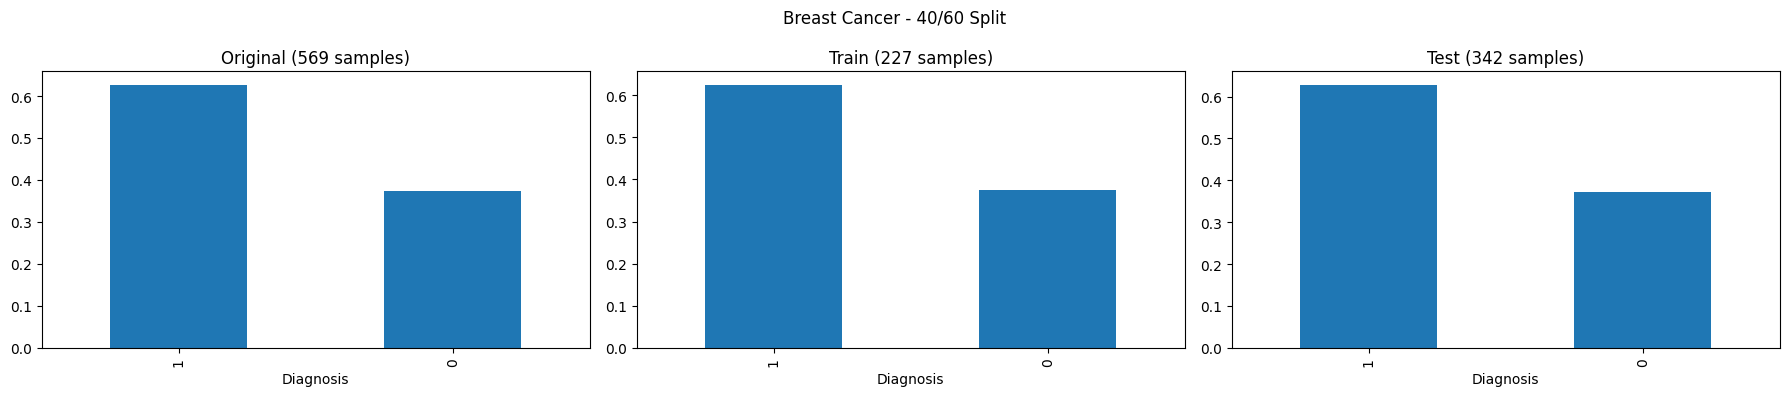

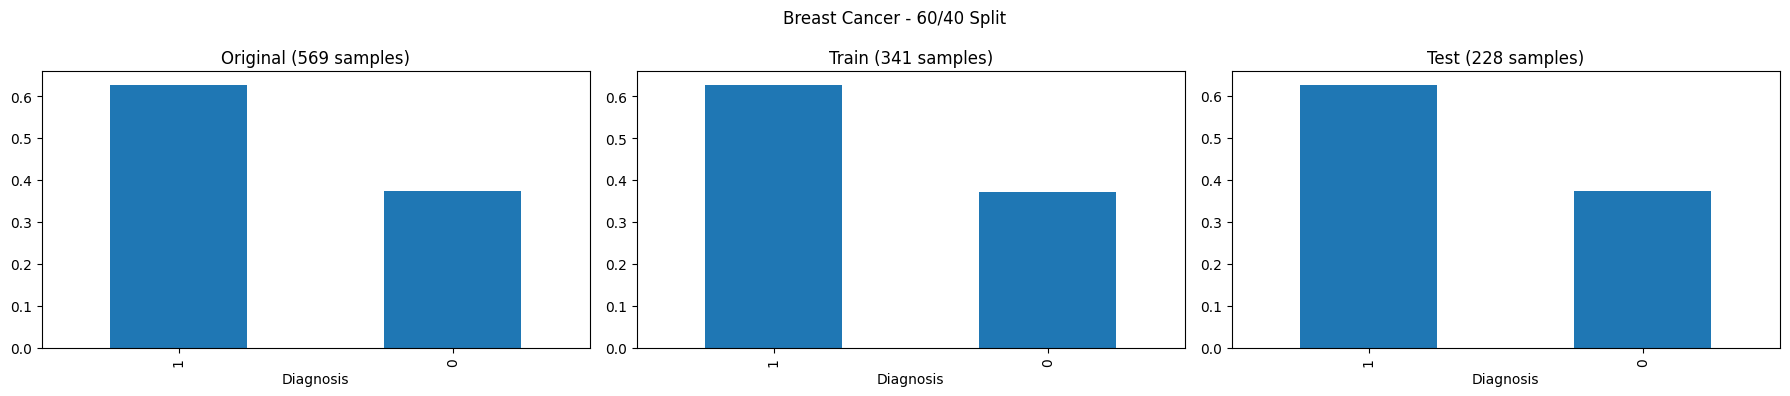

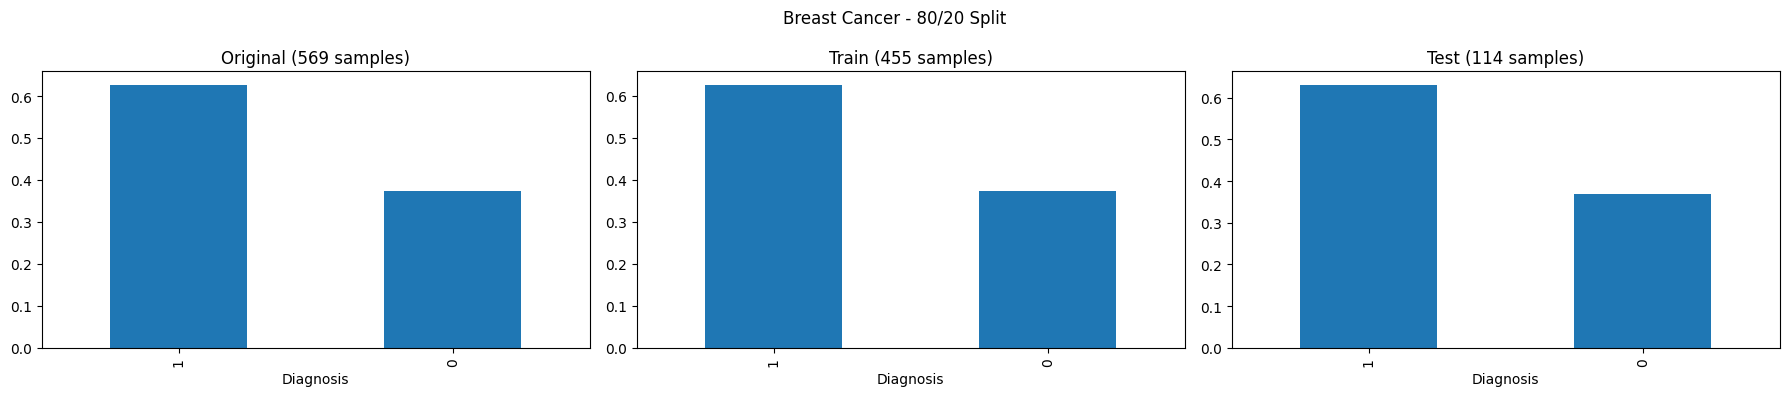

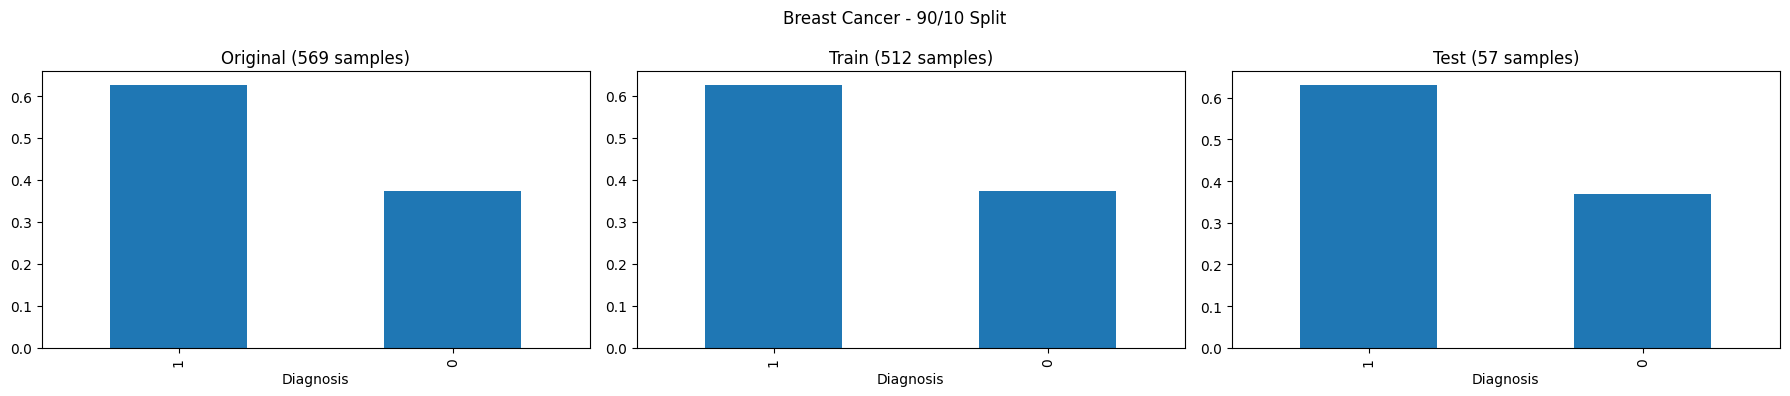


Classification Report (Breast Cancer, 40/60):
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       127
           1       0.95      0.91      0.93       215

    accuracy                           0.91       342
   macro avg       0.90      0.91      0.91       342
weighted avg       0.91      0.91      0.91       342



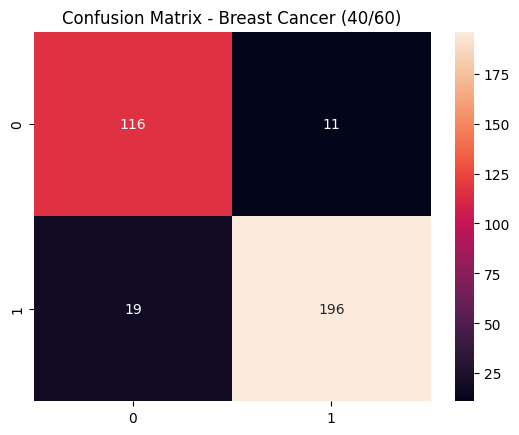

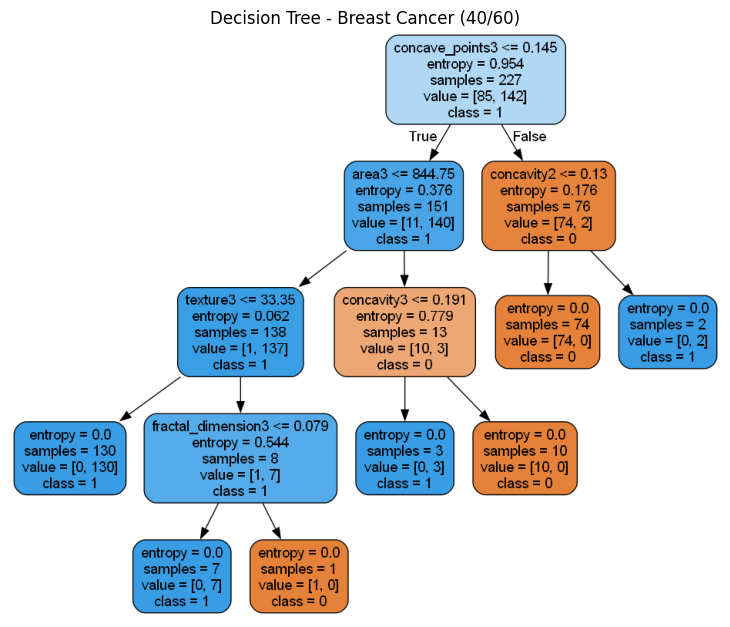


Classification Report (Breast Cancer, 60/40):
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        85
           1       0.96      0.94      0.95       143

    accuracy                           0.93       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.93      0.93      0.93       228



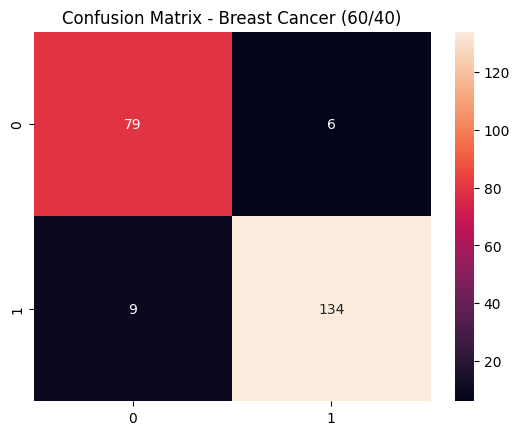

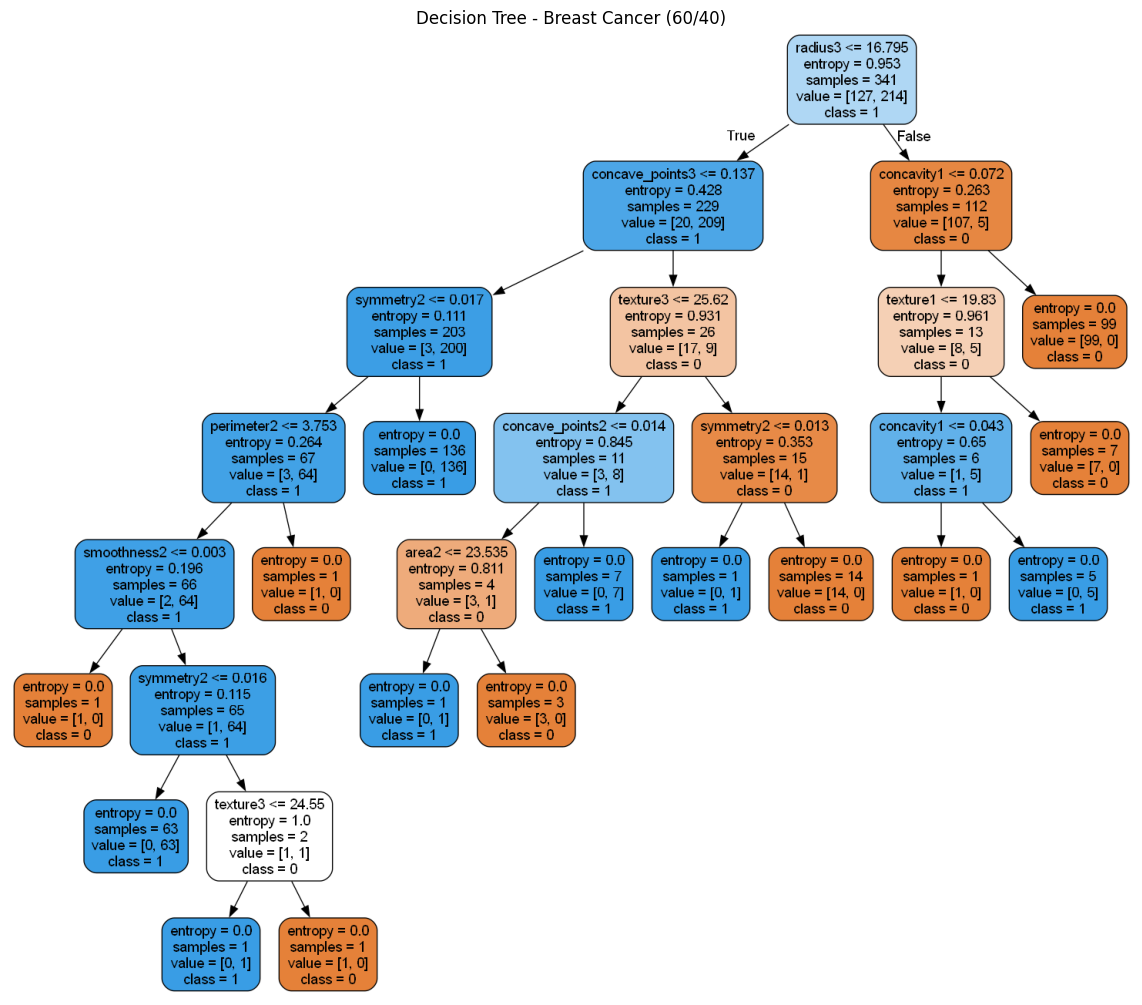


Classification Report (Breast Cancer, 80/20):
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        42
           1       0.97      0.89      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



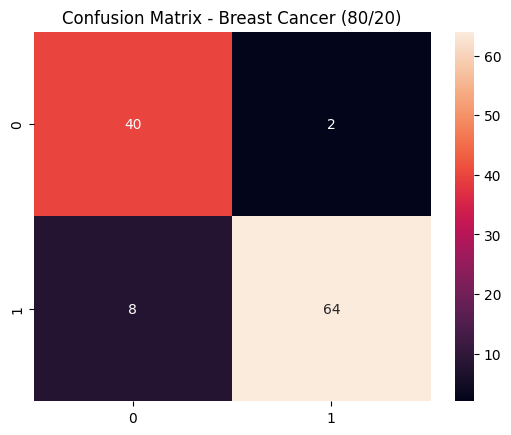

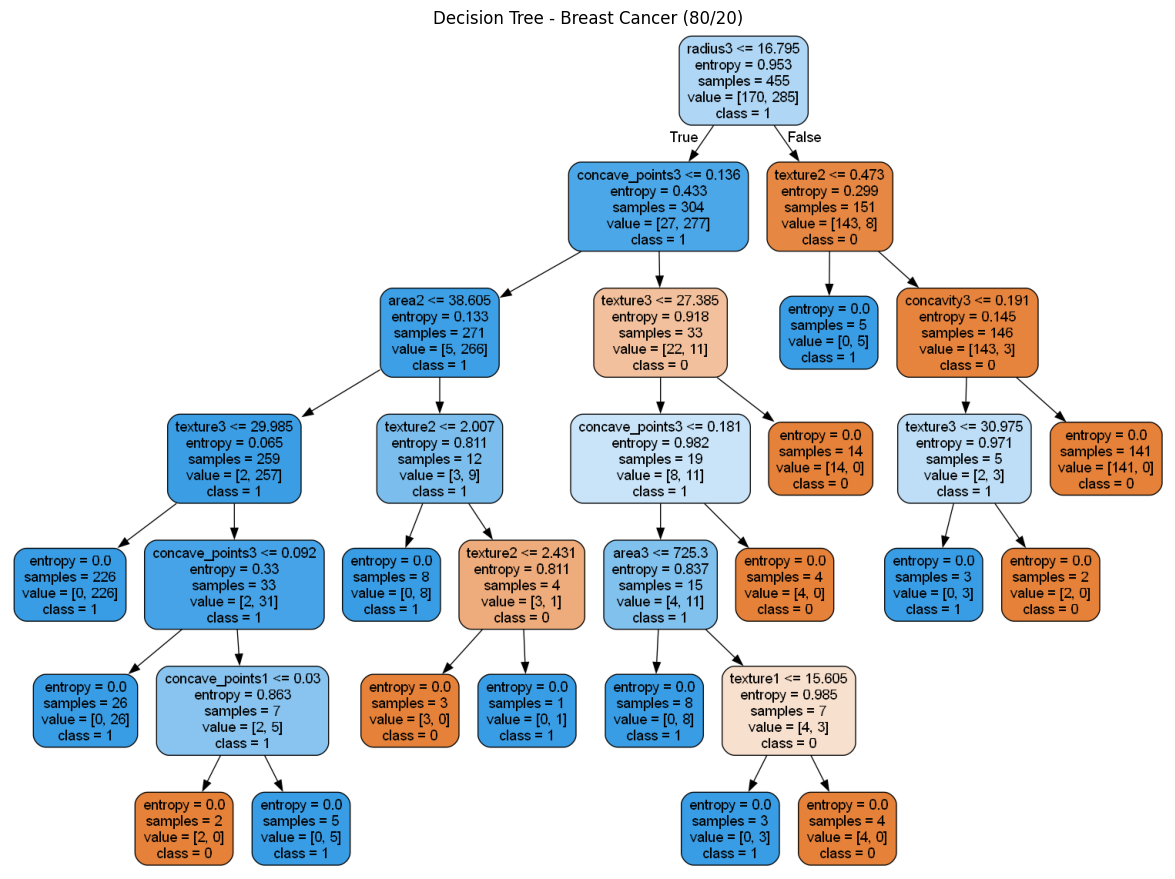


Classification Report (Breast Cancer, 90/10):
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.97      0.83      0.90        36

    accuracy                           0.88        57
   macro avg       0.87      0.89      0.87        57
weighted avg       0.89      0.88      0.88        57



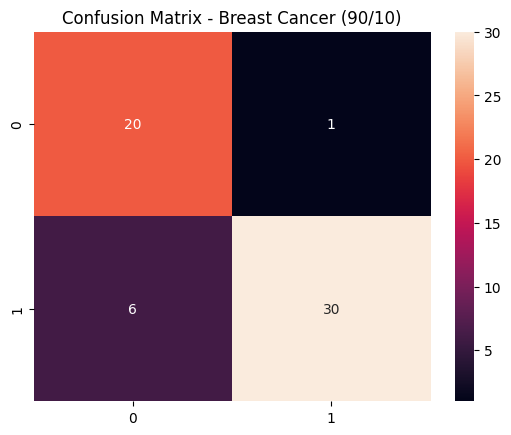

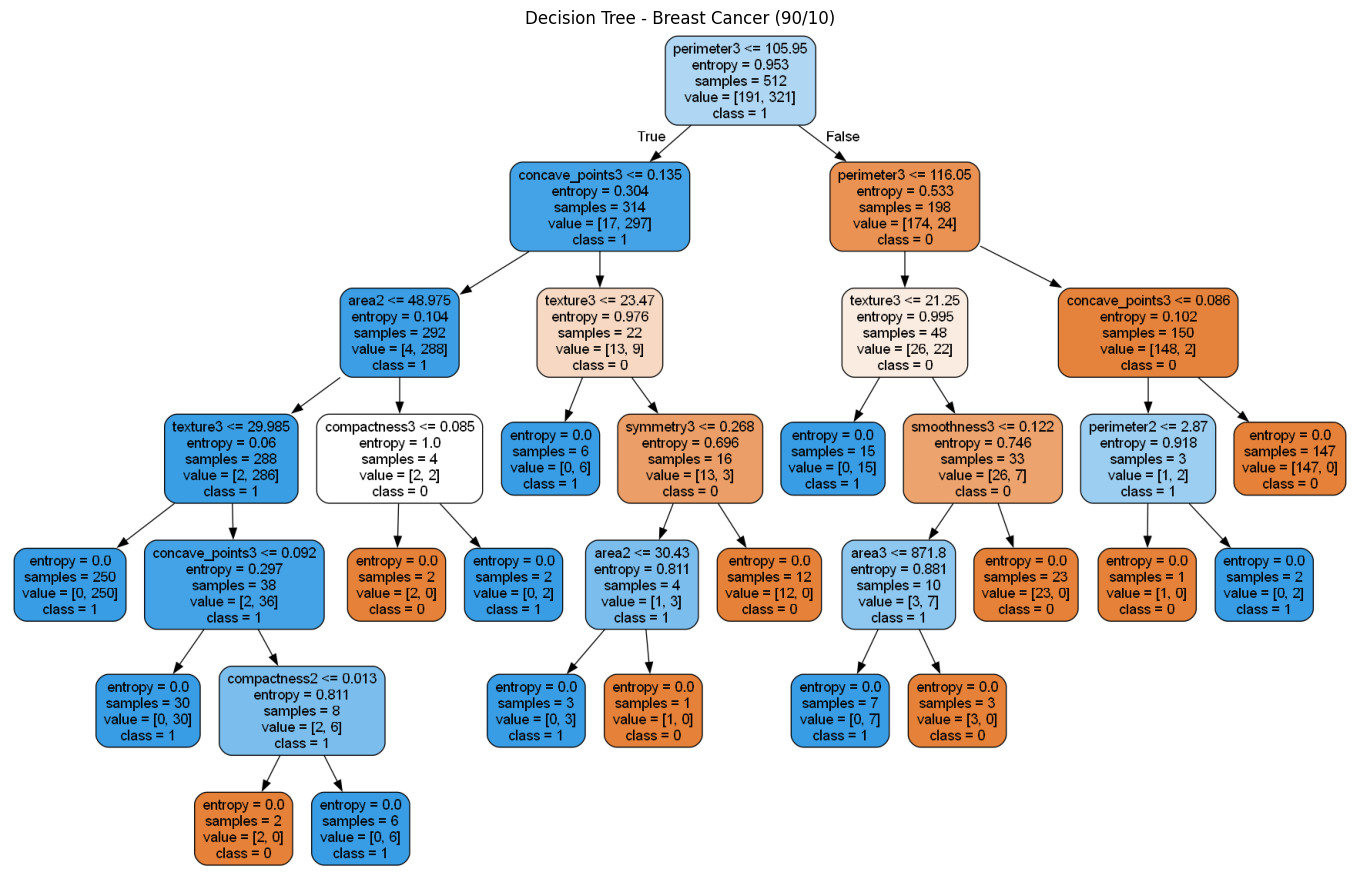

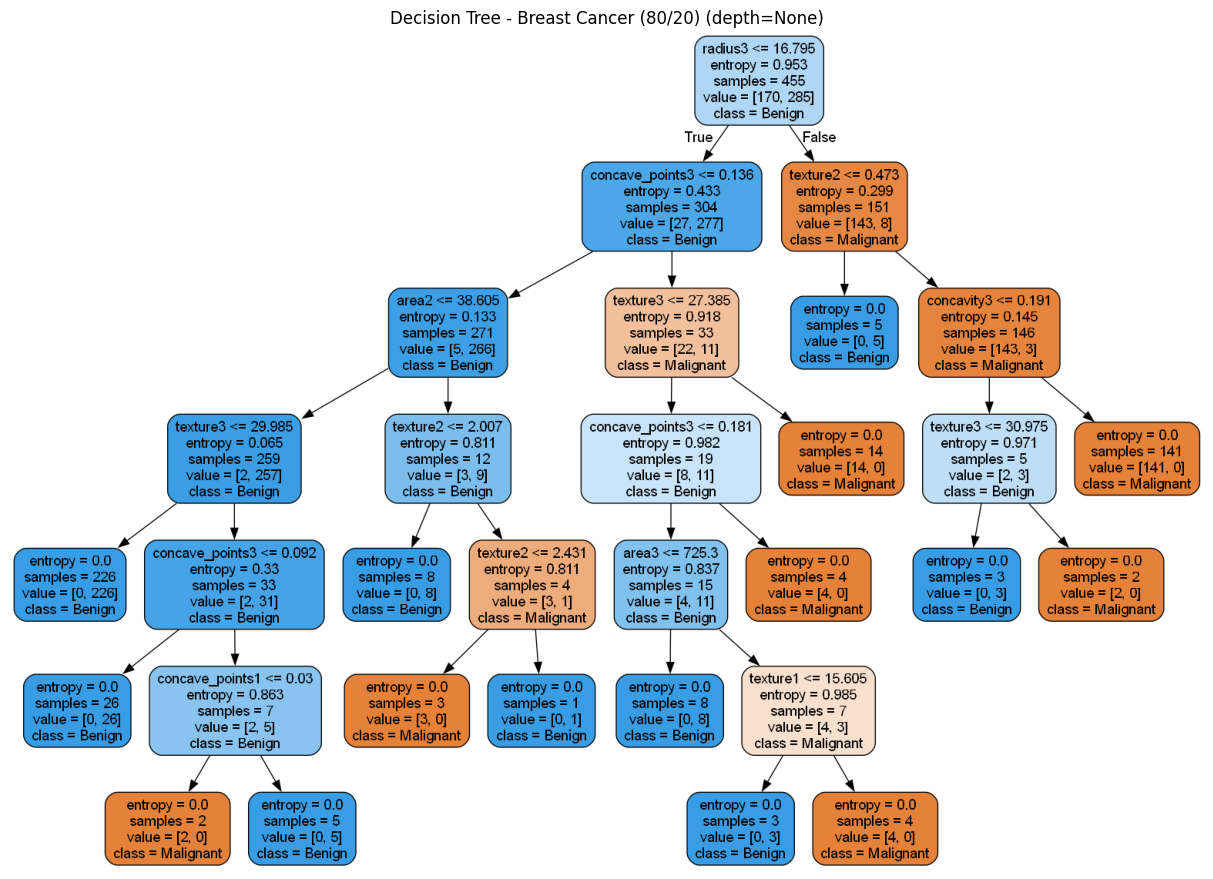

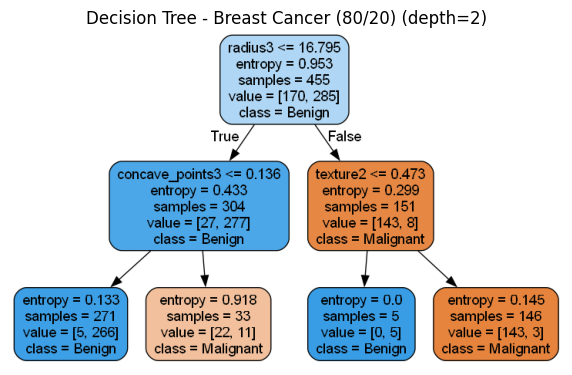

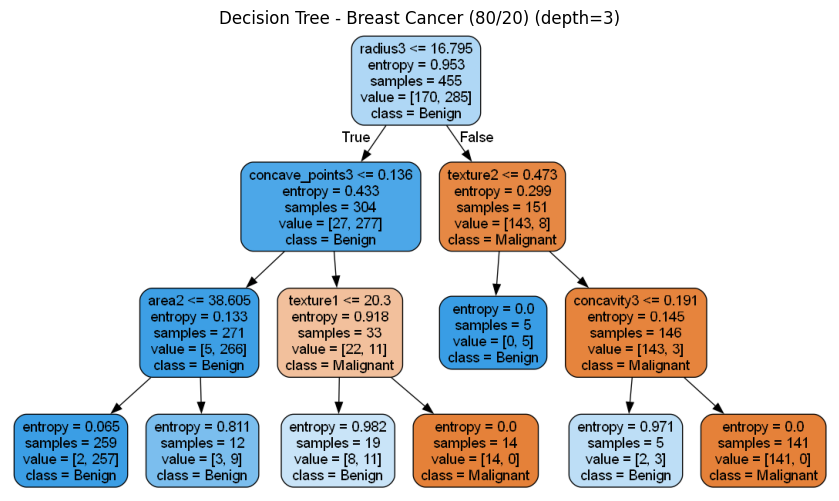

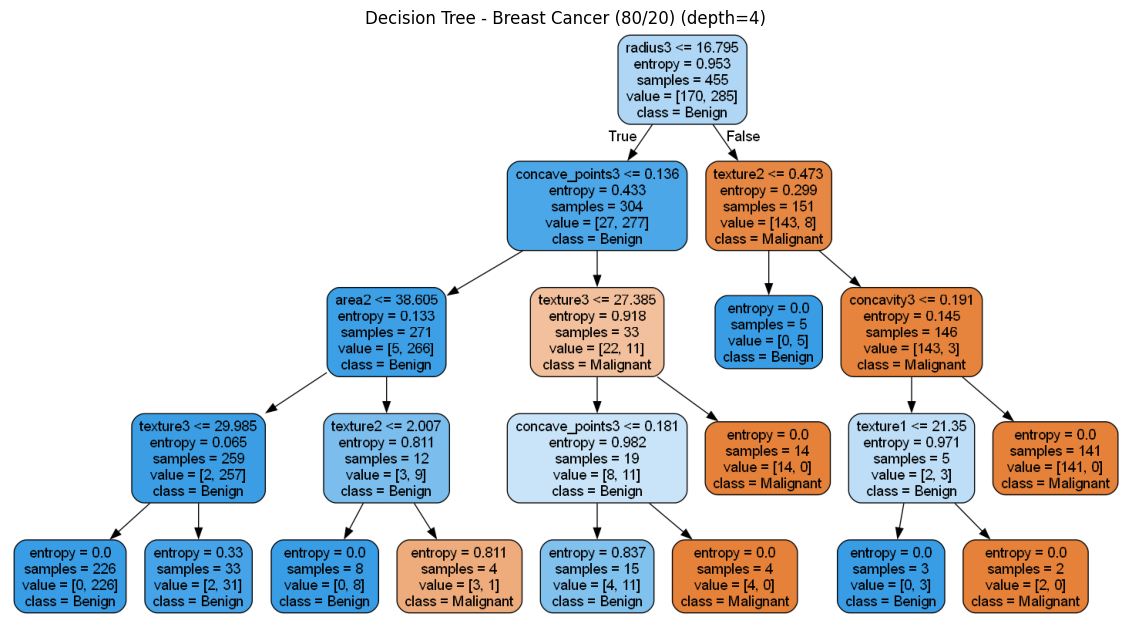

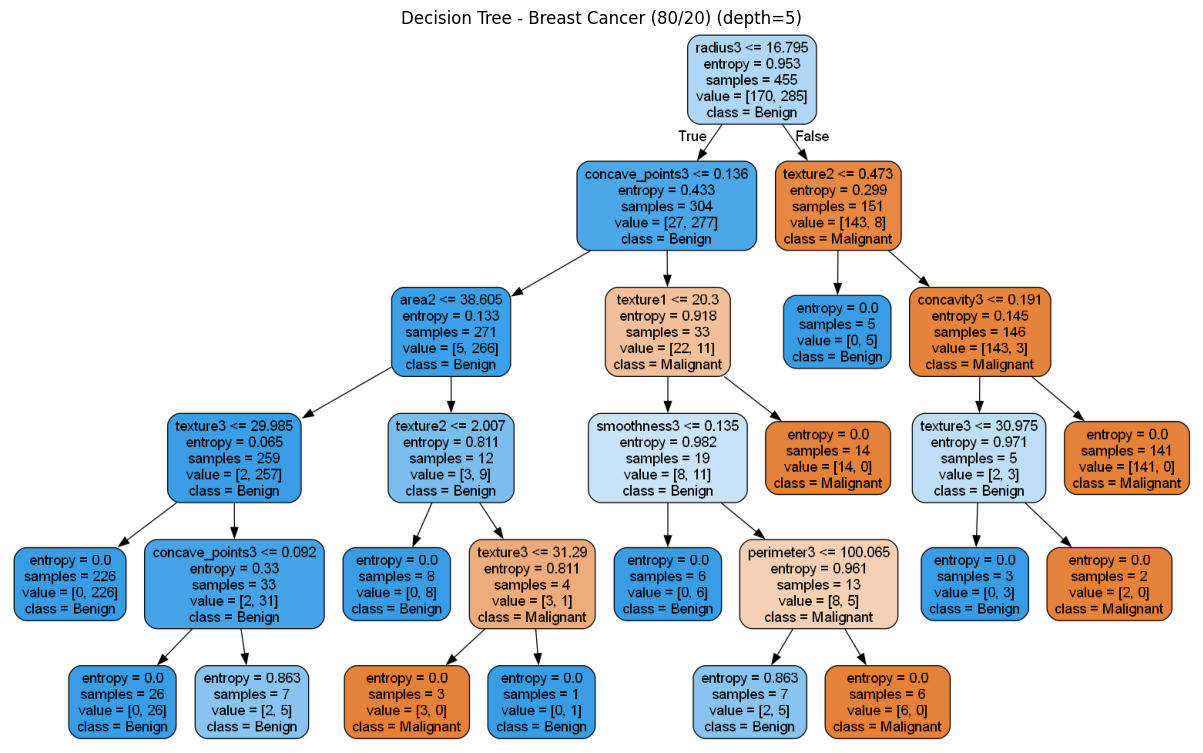

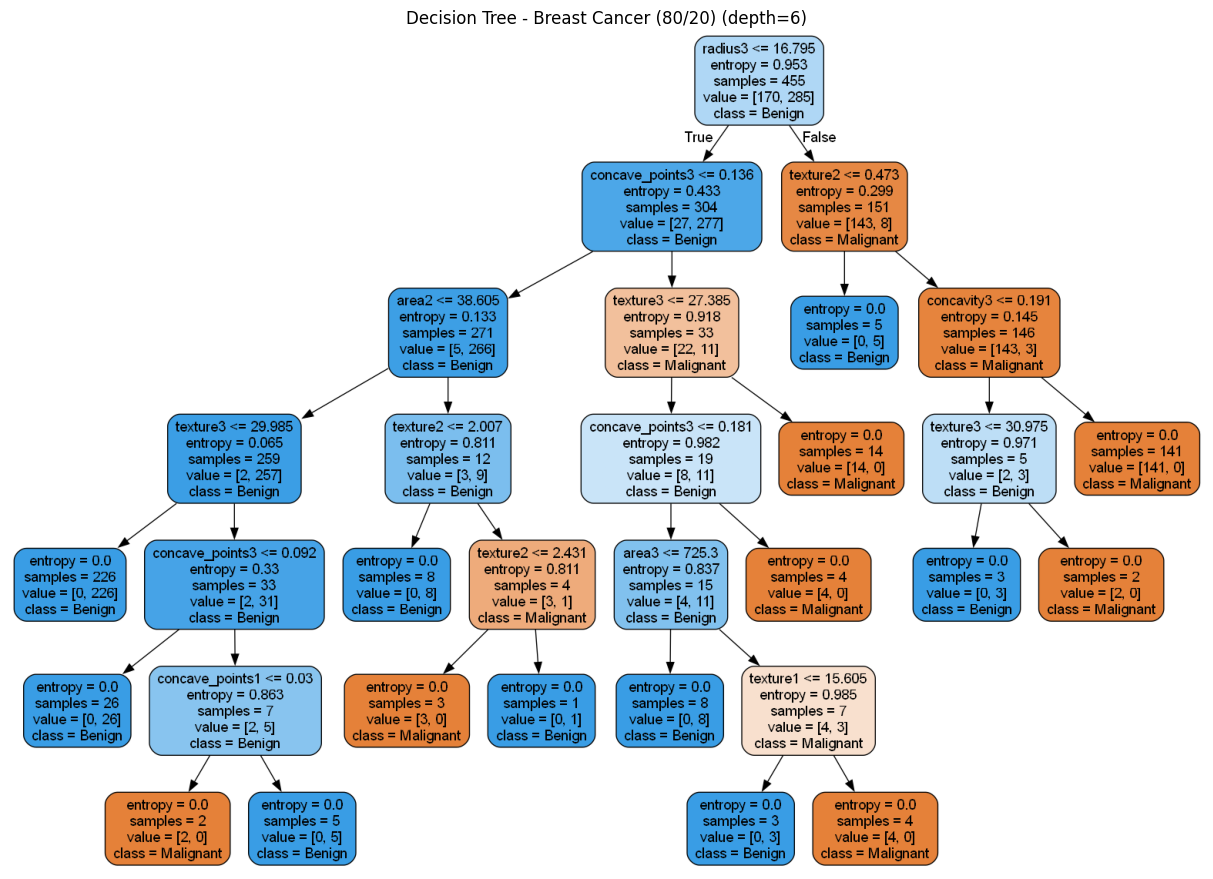

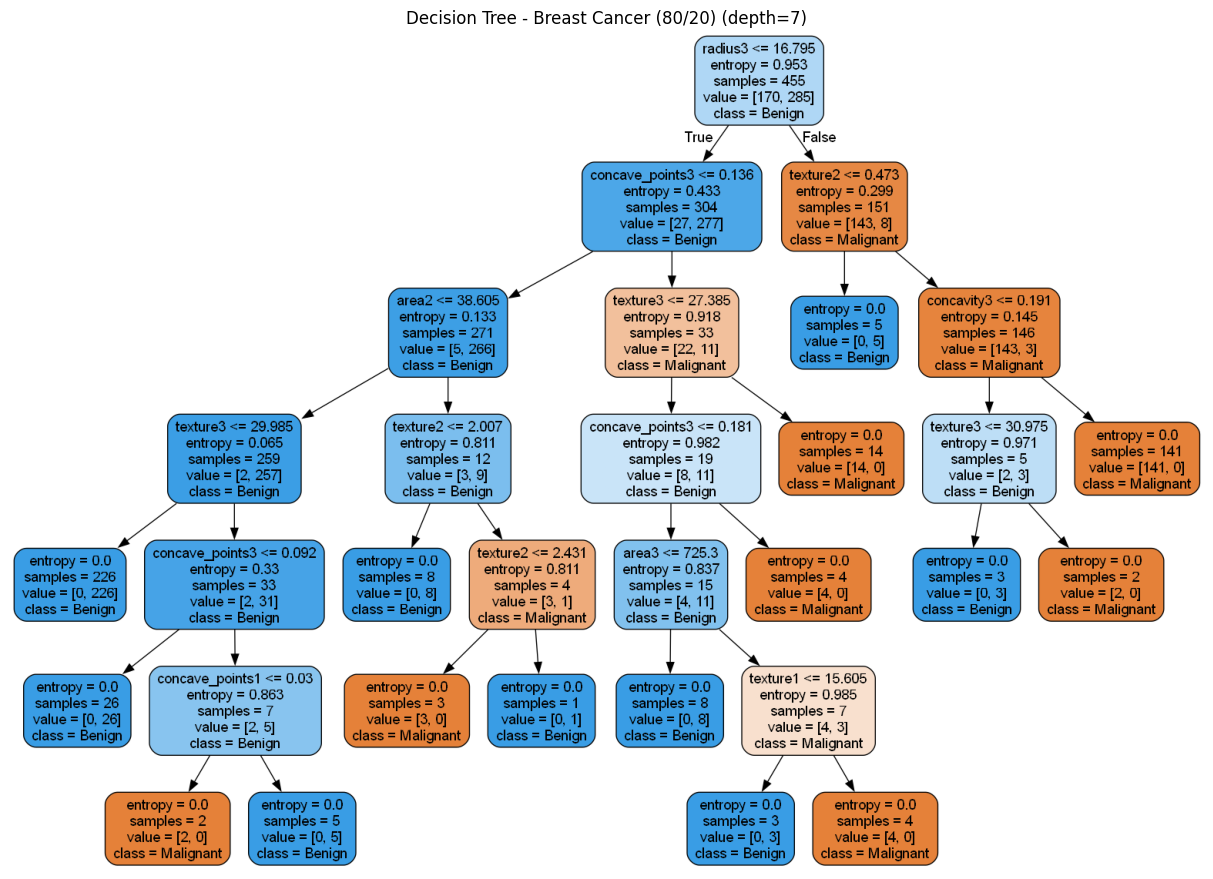

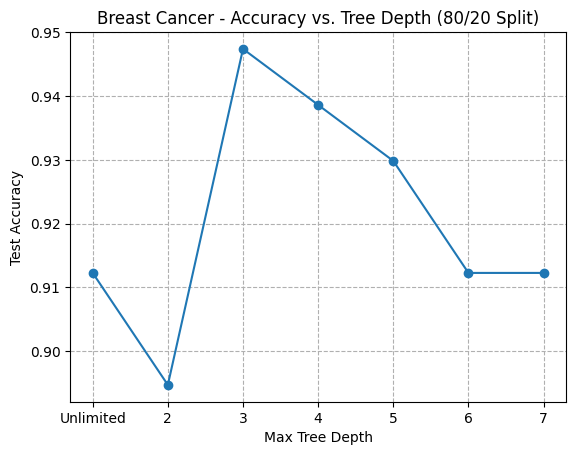


Depth Analysis Results for Breast Cancer:
   Max Depth  Accuracy
0      None  0.912281
1         2  0.894737
2         3  0.947368
3         4  0.938596
4         5  0.929825
5         6  0.912281
6         7  0.912281


In [36]:
dataset_name = "Breast Cancer"

splitted_tests = split_and_visualize(X_breast, y_breast, dataset_name)
for ratio in RATIOS:
    X_train, X_test, y_train, y_test = splitted_tests[ratio]
    train_evaluate_decision_tree(
        X_train,
        y_train,
        X_test,
        y_test,
        dataset_name,
        ratio,
    )

feature_names = X_breast.columns.tolist()
class_names = ["Malignant", "Benign"]  # Must match y_breast.unique()
depth_results = depth_accuracy_analysis(
    X_breast, y_breast, feature_names, class_names, dataset_name
)
print(f"\nDepth Analysis Results for {dataset_name}:\n", depth_results)
